# Machine Learning 3 - Support Vector Machines

A SVM classifier builds a set of hyper-planes to try and separate the data by maximizing the distance between the borders and the data points.

![SVM](http://scikit-learn.org/stable/_images/sphx_glr_plot_separating_hyperplane_0011.png "Decision border in an SVM")

This separation is generally not possible to achieve in the original data space. Therefore, the first step of the SVM is to project the data into a high or infinite dimensions space in which this linear separation can be done. The projection can be done with linear, polynomial, or more comonly "RBF" kernels.

In [1]:
# imports
from lab_tools import CIFAR10, get_hog_image
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
dataset = CIFAR10('data/CIFAR10/')

# data
X_train, y_train = dataset.train['hog'], dataset.train['labels']
X_test, y_test = dataset.test['hog'], dataset.test['labels']

Pre-loading training data
Pre-loading test data


In [3]:
# standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(dataset.train['hog'])
X_test_scaled = scaler.transform(dataset.test['hog'])

**Build a simple SVM** using [the SVC (Support Vector Classfiication) from sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC). 
**Train** it on the CIFAR dataset.

In [ ]:
%%time

# classifier
clf = SVC(kernel='rbf', C=1000.0, gamma=0.0001, random_state=0)

# descriptive performance (on full training set)
clf.fit(X_train_scaled, y_train)
y_train_pred = clf.predict(X_train_scaled)
train_acc = accuracy_score(y_train, y_train_pred)
train_cm = confusion_matrix(y_train, y_train_pred)

print("--- Descriptive performance ---")
print(f"Training accuracy: {train_acc:.4f}")
print("Training confusion matrix:")
print(train_cm)

# predictive performance (5‑fold cross‑validation)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = cross_val_score(
    clf, 
    X_train_scaled, 
    y_train, 
    cv=cv, 
    scoring='accuracy', 
    n_jobs=-1
)
y_cv_pred = cross_val_predict(clf, X_train_scaled, y_train, cv=5)
cv_acc = accuracy_score(y_train, y_cv_pred)
cv_cm = confusion_matrix(y_train, y_cv_pred)

print("\n--- Predictive performance (5‑fold CV) ---")
print("Fold accuracies: ", np.round(cv_scores, 4))
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
print(f"Overall CV accuracy: {cv_acc:.4f}")
print("CV confusion matrix:")
print(cv_cm)

--- Descriptive performance ---
Training accuracy: 0.9451
Training confusion matrix:
[[4750  157   93]
 [ 142 4646  212]
 [  47  172 4781]]

--- Predictive performance (5‑fold CV) ---
Fold accuracies:  [0.806  0.81   0.8193 0.825  0.818 ]
Mean CV accuracy: 0.8157
Overall CV accuracy: 0.8126
CV confusion matrix:
[[4165  586  249]
 [ 607 3813  580]
 [ 204  585 4211]]
CPU times: total: 5min 31s
Wall time: 6min 45s


**Explore the classifier**. How many support vectors are there? What are support vectors?

In [7]:
# how many support vectors?
print("Support vectors per class:", clf.n_support_)
print("Total support vectors: ", clf.n_support_.sum())

# what shape are they?
sv = clf.support_vectors_
print("Shape of support_vectors_:", sv.shape)

# which training‐set indices are used?
sv_idx = clf.support_
print("First 10 support‐vector indices:", sv_idx[:10])

Support vectors per class: [2102 3155 2262]
Total support vectors:  7519
Shape of support_vectors_: (7519, 256)
First 10 support‐vector indices: [ 7  9 16 34 38 49 52 56 60 61]


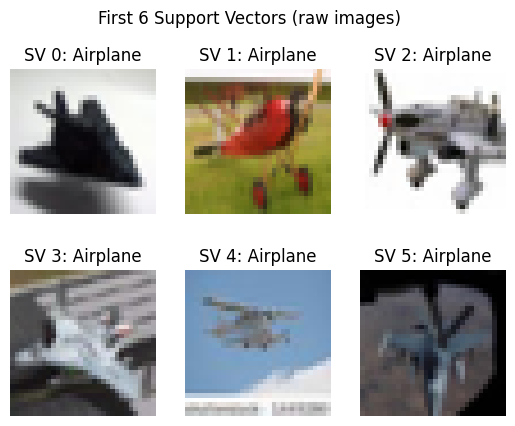

In [ ]:
# svc.support_ gives the indices
for i, idx in enumerate(clf.support_[:6]):
    img = dataset.train['images'][idx].reshape(32,32,3)
    label = dataset.labels[y_train[idx]]
    plt.subplot(2, 3, i+1)
    plt.imshow(img.astype('uint8'))
    plt.title(f"SV {i}: {label}")
    plt.axis('off')
plt.suptitle("First 6 Support Vectors (raw images)")
plt.show()

**Try to find the best "C" (error penalty) and "gamma" parameters** using cross-validation. What influence does "C" have on the number of support vectors?

### kernel = 'rbf'

In [ ]:
%%time

clf = SVC(kernel='rbf', random_state=0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# set up a log‐spaced grid for C and gamma
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
}

# grid search with 5‑fold stratification
grid = GridSearchCV(
    clf,
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)
grid.fit(X_train_scaled, y_train)

# report best hyperparameters
print("\n--- Hyperparameter search results ---")
print(grid.best_params_)
print(f"Best mean 5‑fold CV accuracy: {grid.best_score_:.4f}")

# refit on the full training set and inspect support vectors
best_svc = grid.best_estimator_
best_svc.fit(X_train_scaled, y_train)

print("Support vectors per class:", best_svc.n_support_)
print("Total support vectors: ", best_svc.n_support_.sum())

Fitting 5 folds for each of 25 candidates, totalling 125 fits

--- Hyperparameter search results ---
{'C': 10, 'gamma': 0.001}
Best mean 5‑fold CV accuracy: 0.8153
Support vectors per class: [2228 3287 2351]
Total support vectors:  7866
CPU times: total: 1min 56s
Wall time: 59min 1s


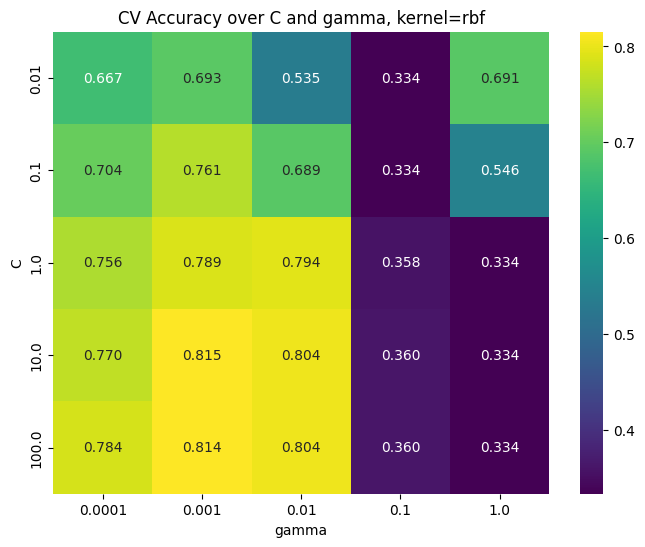

In [ ]:
results = pd.DataFrame(grid.cv_results_)

# pivot into table: rows=C, columns=gamma
pivot = results.pivot(
    index='param_C',
    columns='param_gamma',
    values='mean_test_score'
).astype(float)

plt.figure(figsize=(8,6))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".3f",
    cmap="viridis"
)
plt.xlabel('gamma')
plt.ylabel('C')
plt.title('CV Accuracy over C and gamma, kernel=rbf')
plt.show()

C=  0.01, support vectors per class = [4356 4993 4917], total = 14266
C=   0.1, support vectors per class = [2914 4315 3596], total = 10825
C=     1, support vectors per class = [2316 3475 2604], total = 8395
C=    10, support vectors per class = [2228 3287 2351], total = 7866
C=   100, support vectors per class = [2338 3396 2506], total = 8240


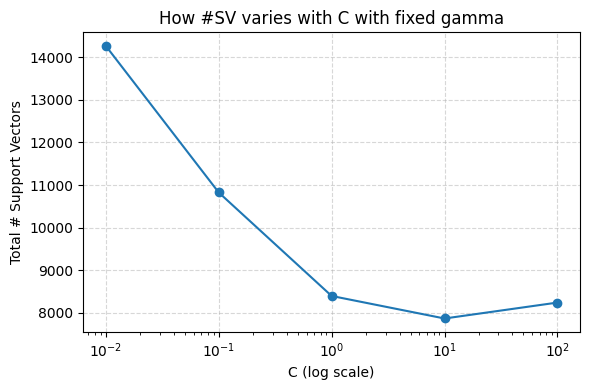

In [4]:
# the list of C’s you want to inspect
C_values = [0.01, 0.1, 1, 10, 100]

sv_counts = []
for C in C_values:
    # fit a fresh SVC with this C and the best gamma
    svc = SVC(kernel='rbf', C=C, gamma=0.001, random_state=0)
    svc.fit(X_train_scaled, y_train)
    
    # record total number of support vectors
    total_sv = svc.n_support_.sum()
    sv_counts.append(total_sv)
    print(f"C={C:>6}, support vectors per class = {svc.n_support_}, total = {total_sv}")

# now plot
plt.figure(figsize=(6,4))
plt.plot(C_values, sv_counts, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel("C (log scale)")
plt.ylabel("Total # Support Vectors")
plt.title("How #SV varies with C with fixed gamma")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### How the SVM regularization parameter _C_ affects support vectors

- **_C_ controls the the trade‐off between margin width and misclassification penalty**  
  - A **small _C_** heavily penalizes model complexity and **favors a wide margin**, even if that means misclassifying some points.  
  - A **large _C_** strongly penalizes misclassification and **forces a tighter margin** to correctly separate more training examples.

- **Impact on support vectors**  
  - **Low _C_ ⇒ more support vectors**  
    - Many points can lie **inside** or **on** the wide margin, so they all become support vectors.  
  - **Increasing _C_ ⇒ fewer support vectors**  
    - The model “pushes” non-critical points outside the margin, so only the hardest-to-separate points remain as support vectors.  
  - **Very large _C_ ⇒ slight rebound**  
    - Once misclassification becomes intolerably costly, the margin shrinks tightly around borderline cases, and a few additional outliers may re-enter as support vectors.

### kernel = 'poly'

In [15]:
%%time
from sklearn.model_selection import GridSearchCV

clf = SVC(kernel='poly', random_state=0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# set up a log‐spaced grid for C and gamma
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
}

# grid search with 5‑fold stratification
grid = GridSearchCV(
    clf,
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)
grid.fit(X_train_scaled, y_train)

# report best hyperparameters
print("\n--- Hyperparameter search results ---")
print(grid.best_params_)
print(f"Best mean 5‑fold CV accuracy: {grid.best_score_:.4f}")

# refit on the full training set and inspect support vectors
best_svc = grid.best_estimator_
best_svc.fit(X_train_scaled, y_train)

print("Support vectors per class:", best_svc.n_support_)
print("Total support vectors: ", best_svc.n_support_.sum())

Fitting 5 folds for each of 25 candidates, totalling 125 fits

--- Hyperparameter search results ---
{'C': 0.01, 'gamma': 0.1}
Best mean 5‑fold CV accuracy: 0.8004
Support vectors per class: [2724 3937 3447]
Total support vectors:  10108
CPU times: total: 4min 21s
Wall time: 53min 59s


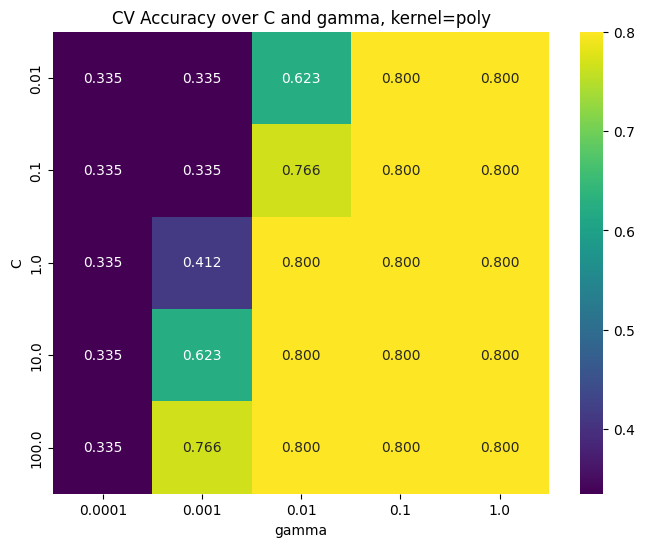

In [16]:
results = pd.DataFrame(grid.cv_results_)

# pivot into table: rows=C, columns=gamma
pivot = results.pivot(
    index='param_C',
    columns='param_gamma',
    values='mean_test_score'
).astype(float)

plt.figure(figsize=(8,6))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".3f",
    cmap="viridis"
)
plt.xlabel('gamma')
plt.ylabel('C')
plt.title('CV Accuracy over C and gamma, kernel=poly')
plt.show()

In [6]:
%%time

# final model
svm = SVC(C=10, kernel='rbf', gamma=0.001, random_state=0)

# (re-)fit it on the *entire* training set
svm.fit(X_train_scaled, y_train)

# predict on the test set
y_test_pred = svm.predict(X_test_scaled)

# compute and print your final metrics
test_acc = accuracy_score(y_test, y_test_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

print("--- Final Test-Set Performance ---")
print(f"Test accuracy: {test_acc:.4f}\n")
print("Confusion matrix:")
print(test_cm, "\n")
print("Classification report:")
print(classification_report(y_test, y_test_pred, target_names=dataset.labels))

--- Final Test-Set Performance ---
Test accuracy: 0.8233

Confusion matrix:
[[848 116  36]
 [106 776 118]
 [ 29 125 846]] 

Classification report:
              precision    recall  f1-score   support

    Airplane       0.86      0.85      0.86      1000
        Bird       0.76      0.78      0.77      1000
       Horse       0.85      0.85      0.85      1000

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000

CPU times: total: 49.5 s
Wall time: 57.1 s


# Comparing algorithms

Using the best hyper-parameters that you found for each of the algorithms (kNN, Decision Trees, Random Forests, MLP, SVM):

* Re-train the models on the full training set.
* Compare their results on the test set.

In [5]:
from sklearn.pipeline import Pipeline

# define the three classifiers
models = {
    'Ridge': RidgeClassifier(alpha=0.1),
    "K‑Nearest Neighbors": KNeighborsClassifier(metric="manhattan", n_neighbors=7),
    "Decision Tree": DecisionTreeClassifier(
        criterion="gini", max_depth=7, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        max_depth=10, n_estimators=50, random_state=42
    ),
    "Multi-Layer Perceptron": MLPClassifier(
        hidden_layer_sizes=(100,),
        activation="relu",
        alpha=0.001,
        learning_rate_init=0.001,
        max_iter=300,
        random_state=0,
    ),
    "Support Vector Machines": SVC(C=10, kernel="rbf", gamma=0.001, random_state=0),
}

# set up a stratified 5-fold splitter for CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# loop over each model
for name, estimator in models.items():
    print(f"\n------ {name} ------")

    # build pipeline: standardization + classifier
    pipe = Pipeline([("scaler", StandardScaler()), ("clf", estimator)])

    # descriptive performance
    pipe.fit(X_train, y_train)
    y_train_pred = pipe.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_cm = confusion_matrix(y_train, y_train_pred)

    print("-- Descriptive performance --")
    print(f"Training accuracy: {train_acc:.4f}")
    print("Training confusion matrix:")
    print(train_cm)

    # predictive performance (5‑fold cross‑validation)
    cv_scores = cross_val_score(
        pipe, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1
    )
    y_cv_pred = cross_val_predict(pipe, X_train, y_train, cv=cv, n_jobs=-1)
    cv_acc = accuracy_score(y_train, y_cv_pred)
    cv_cm = confusion_matrix(y_train, y_cv_pred)

    print("\n-- Predictive performance (5‑fold CV) --")
    print("Fold accuracies: ", np.round(cv_scores, 4))
    print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
    print(f"Overall CV accuracy: {cv_acc:.4f}")
    print("CV confusion matrix:")
    print(cv_cm)

    # final Test-Set performance
    pipe.fit(X_train, y_train)
    y_test_pred = pipe.predict(X_test)

    test_acc = accuracy_score(y_test, y_test_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)

    print("\n-- Final Test-Set Performance --")
    print(f"Test accuracy: {test_acc:.4f}\n")
    print("Confusion matrix:")
    print(f"{test_cm}\n")


------ Ridge ------
-- Descriptive performance --
Training accuracy: 0.7596
Training confusion matrix:
[[3866  679  455]
 [ 641 3481  878]
 [ 256  697 4047]]

-- Predictive performance (5‑fold CV) --
Fold accuracies:  [0.7317 0.7557 0.7553 0.736  0.7527]
Mean CV accuracy: 0.7463
Overall CV accuracy: 0.7463
CV confusion matrix:
[[3814  714  472]
 [ 669 3401  930]
 [ 281  740 3979]]

-- Final Test-Set Performance --
Test accuracy: 0.7430

Confusion matrix:
[[765 160  75]
 [123 671 206]
 [ 50 157 793]]


------ K‑Nearest Neighbors ------
-- Descriptive performance --
Training accuracy: 0.8475
Training confusion matrix:
[[4175  579  246]
 [ 349 4231  420]
 [  91  602 4307]]

-- Predictive performance (5‑fold CV) --
Fold accuracies:  [0.7773 0.7917 0.7813 0.791  0.785 ]
Mean CV accuracy: 0.7853
Overall CV accuracy: 0.7853
CV confusion matrix:
[[3864  795  341]
 [ 455 3919  626]
 [ 140  864 3996]]

-- Final Test-Set Performance --
Test accuracy: 0.7897

Confusion matrix:
[[782 162  56]
 [ 8

### Model Performance Comparison

| Model | Train Acc | CV Acc | Test Acc | Train-Test Gap |
| :--- | :---: | :---: | :---: | :---: |
| Ridge | 75.96% | 74.63% | 74.30% | ~1.7 pp |
| K-Nearest Neighbors | 84.75% | 78.53% | 78.97% | ~5.8 pp |
| Decision Tree | 66.91% | 59.39% | 60.17% | ~6.7 pp |
| Random Forest | 93.40% | 74.24% | 74.23% | ~19.2 pp |
| Multi-Layer Perceptron | 100.00% | 79.55% | 80.00% | ~20 pp |
| Support Vector Machine | 93.77% | 81.66% | 82.33% | ~11.4 pp |



- Overall Results
    - **Best Overall:** The **Support Vector Machine (SVM)** is the top performer, achieving **82.3%** on the held-out test set.
    - **Close Second:** The **Multi-Layer Perceptron (MLP)** follows closely with **80.0%** test accuracy.

- Key Observations
    - **Strong Learners (RF, MLP, SVM):**
        - All models with high expressive power (Random Forest, MLP, SVM) significantly overfit their training data.
        - However, the **SVM** strikes the best balance between fitting the data and generalizing to new, unseen data.
    - **Competitive Baseline (K-NN):**
        - **K-Nearest Neighbors** proves to be a simple yet strong non-parametric baseline, reaching **79.0%** test accuracy with only moderate overfitting.
    - **Simpler Models:**
        - The linear **Ridge** model performs reasonably well (**74.3%**), but it cannot keep up with the more complex models.
        - A single **Decision Tree** is too weak on its own (**60%**), highlighting the need for techniques like ensembling (which is what Random Forest does) or pruning to improve its performance.

For classifying the CIFAR-3 (since we are using only 3 classes) dataset using HOG features, a well-tuned **SVM is the best choice**. The **MLP** is a very close second, and **K-NN** stands out as a solid, simpler alternative.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# define the three classifiers
models = {
    'Ridge': RidgeClassifier(alpha=0.1),
    "K‑Nearest Neighbors": KNeighborsClassifier(metric="manhattan", n_neighbors=7),
    "Decision Tree": DecisionTreeClassifier(
        criterion="gini", max_depth=7, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        max_depth=10, n_estimators=50, random_state=42
    ),
    "Multi-Layer Perceptron": MLPClassifier(
        hidden_layer_sizes=(100,),
        activation="relu",
        alpha=0.001,
        learning_rate_init=0.001,
        max_iter=300,
        random_state=0,
    ),
    "Support Vector Machines": SVC(C=10, kernel="rbf", gamma=0.001, random_state=0),
}

# set up a stratified 5-fold splitter for CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# loop over each model
for name, estimator in models.items():
    print(f"\n------ {name} ------")

    # build pipeline: standardization + classifier
    pipe = Pipeline([("scaler", StandardScaler()), 
                     ('pca', PCA(n_components=0.90, whiten=True, random_state=42)),
                     ("clf", estimator)])

    # descriptive performance
    pipe.fit(X_train, y_train)
    y_train_pred = pipe.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_cm = confusion_matrix(y_train, y_train_pred)

    print("-- Descriptive performance --")
    print(f"Training accuracy: {train_acc:.4f}")
    print("Training confusion matrix:")
    print(train_cm)

    # predictive performance (5‑fold cross‑validation)
    cv_scores = cross_val_score(
        pipe, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1
    )
    y_cv_pred = cross_val_predict(pipe, X_train, y_train, cv=cv, n_jobs=-1)
    cv_acc = accuracy_score(y_train, y_cv_pred)
    cv_cm = confusion_matrix(y_train, y_cv_pred)

    print("\n-- Predictive performance (5‑fold CV) --")
    print("Fold accuracies: ", np.round(cv_scores, 4))
    print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
    print(f"Overall CV accuracy: {cv_acc:.4f}")
    print("CV confusion matrix:")
    print(cv_cm)

    # final Test-Set performance
    pipe.fit(X_train, y_train)
    y_test_pred = pipe.predict(X_test)

    test_acc = accuracy_score(y_test, y_test_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)

    print("\n-- Final Test-Set Performance --")
    print(f"Test accuracy: {test_acc:.4f}\n")
    print("Confusion matrix:")
    print(f"{test_cm}\n")


------ Ridge ------
-- Descriptive performance --
Training accuracy: 0.7531
Training confusion matrix:
[[3862  689  449]
 [ 653 3428  919]
 [ 266  727 4007]]

-- Predictive performance (5‑fold CV) --
Fold accuracies:  [0.735  0.75   0.7503 0.7413 0.7523]
Mean CV accuracy: 0.7458
Overall CV accuracy: 0.7458
CV confusion matrix:
[[3823  707  470]
 [ 665 3394  941]
 [ 288  742 3970]]

-- Final Test-Set Performance --
Test accuracy: 0.7427

Confusion matrix:
[[767 160  73]
 [119 674 207]
 [ 51 162 787]]


------ K‑Nearest Neighbors ------
-- Descriptive performance --
Training accuracy: 0.7379
Training confusion matrix:
[[3225 1179  596]
 [ 277 4094  629]
 [ 118 1132 3750]]

-- Predictive performance (5‑fold CV) --
Fold accuracies:  [0.6153 0.6453 0.614  0.6107 0.6233]
Mean CV accuracy: 0.6217
Overall CV accuracy: 0.6217
CV confusion matrix:
[[2555 1652  793]
 [ 390 3645  965]
 [ 145 1729 3126]]

-- Final Test-Set Performance --
Test accuracy: 0.6357

Confusion matrix:
[[528 345 127]
 [ 7